In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
from datetime import datetime, timedelta

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import pyepsg
import scipy.optimize
from shapely.geometry import (Polygon, Point, box)
import xarray as xr
import regionmask
from PyAstronomy import pyasl
from scipy import signal
    
from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis)
from himatpy.LIS import utils as LISutils

import pickle
import matplotlib.pyplot as plt

In [2]:
gracedat = '../../files/GRACE/GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
lisdat = '../../files/LIS/LIS_by_mascon.pkl'

In [3]:
g = extract_grace(gracedat)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [4]:
mascon = g['mascon']
soln = g['solution']
mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


In [5]:
mascon_gdf.head()

,area_deg,area_km2,basin,elev_flag,lat_center,lat_span,location,lon_center,lon_span,geometry,mascon
0,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,289.459459,4.864865,"POLYGON ((291.89189195 77.5, 291.89189195 78.5...",0
1,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,294.324324,4.864865,"POLYGON ((296.75675675 77.5, 296.75675675 78.5...",1
2,1.011449,12453.61,1.1,1.0,78.0,1.0,1.0,299.189189,4.864865,"POLYGON ((301.62162165 77.5, 301.62162165 78.5...",2
3,1.010152,12437.07,1.1,1.0,79.0,1.0,1.0,293.823529,5.294118,"POLYGON ((296.4705882 78.5, 296.4705882 79.5, ...",3
4,1.010152,12437.07,1.1,1.0,79.0,1.0,1.0,299.117647,5.294118,"POLYGON ((301.7647059 78.5, 301.7647059 79.5, ...",4


## Get LIS DATAFRAME FROM PICKLE

In [6]:
# dropping mask, not needed for graph
lisdf = pickle.load(open(lisdat, 'rb')).reset_index(drop=True, level=0)

In [7]:
# unique mascon id's for region
masconsid = lisdf['mascon'].unique()

In [8]:
masconsid

array([ 8119,  8125,  8118,  8123,  8021,  8122,  7749,  7763,  7748,
        6809,  7765,  7764,  8121,  8127,  8120,  8126,  8124,  9972,
        7744,  7758,  8019,  7745,  7759,  8024,  8018,  8023,  8017,
        8022,  8020,  9977,  7746,  7760,  7762,  7747,  7761,  7776,
        8027,  8028,  8130,  7782,  7801,  7781,  8029,  8035,  8030,
        8036,  8033,  8026,  8025,  8031,  8032,  8034,  8128,  9951,
        7783,  7802,  7803,  8129,  8131,  7800,  7780,  8132,  7795,
        7779,  7798,  7778,  7799,  7777,  7796,  7797,  9960,  8037,
        8038,  8039,  8040,  8041,  8042,  7813,  7814,  7815,  7816,
        8133,  7817,  7820,  7818,  7819,  7821,  7822,  7837,  7854,
        7836,  7840,  7858,  8043,  8048,  8134,  8046,  8051,  8045,
        8050,  8044,  8135,  7832,  7849,  7831,  7833,  7850,  7853,
        7835,  8049,  7857,  7839,  9969,  7852,  7886,  7856,  7855,
        8005,  8004,  8003,  8002,  7851,  7999,  8000,  8052,  8001,
        7866,  7867,

In [9]:
lisdf.head()

,Evap_tavg,Rainf_tavg,Qs_tavg,Snowf_tavg,Qsm_tavg,Qsb_tavg,mascon,waterbal,waterbal_cumulative
time,,,,,,,,,
2001-01-01,0.000058,0.000028,2.968408e-07,1.591237e-07,0.0,0.000003,8119,-0.000036,-0.000036
2001-02-01,0.000042,0.000069,7.447817e-07,9.335977e-09,0.0,0.000003,8119,0.000021,-0.000015
2001-03-01,0.000108,0.000112,1.216483e-06,4.869142e-08,0.0,0.000003,8119,-0.000003,-0.000018
2001-04-01,0.000201,0.000206,2.225385e-06,0.000000e+00,0.0,0.000003,8119,-0.000002,-0.000019
2001-05-01,0.000107,0.000063,6.788835e-07,0.000000e+00,0.0,0.000003,8119,-0.000051,-0.000070


## Make GRACE DATAFRAME IN REGION

In [10]:
## get the mascon time series
t = pd.DataFrame(data = {
    'time': g['time']["ref_days_middle"][0,:]
})

In [11]:
grc_lst = []
for m in masconsid:
    df = pd.DataFrame(data={
        'cmwe': soln['cmwe'][m][:] * 10,
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)

In [12]:
gracedf = pd.concat(grc_lst)

In [13]:
gracedf.head()

,cmwe,mascon
time,,
2003-01-06 12:00:00,-35.208430,8119
2003-02-21 00:00:00,-2.004382,8119
2003-03-16 00:00:00,5.896959,8119
2003-04-15 12:00:00,-42.092590,8119
2003-05-07 12:00:00,-21.614554,8119


## Perform analysis (Single Mascon)

In [14]:
masconid = 8064

In [15]:
lisdf.head()

,Evap_tavg,Rainf_tavg,Qs_tavg,Snowf_tavg,Qsm_tavg,Qsb_tavg,mascon,waterbal,waterbal_cumulative
time,,,,,,,,,
2001-01-01,0.000058,0.000028,2.968408e-07,1.591237e-07,0.0,0.000003,8119,-0.000036,-0.000036
2001-02-01,0.000042,0.000069,7.447817e-07,9.335977e-09,0.0,0.000003,8119,0.000021,-0.000015
2001-03-01,0.000108,0.000112,1.216483e-06,4.869142e-08,0.0,0.000003,8119,-0.000003,-0.000018
2001-04-01,0.000201,0.000206,2.225385e-06,0.000000e+00,0.0,0.000003,8119,-0.000002,-0.000019
2001-05-01,0.000107,0.000063,6.788835e-07,0.000000e+00,0.0,0.000003,8119,-0.000051,-0.000070


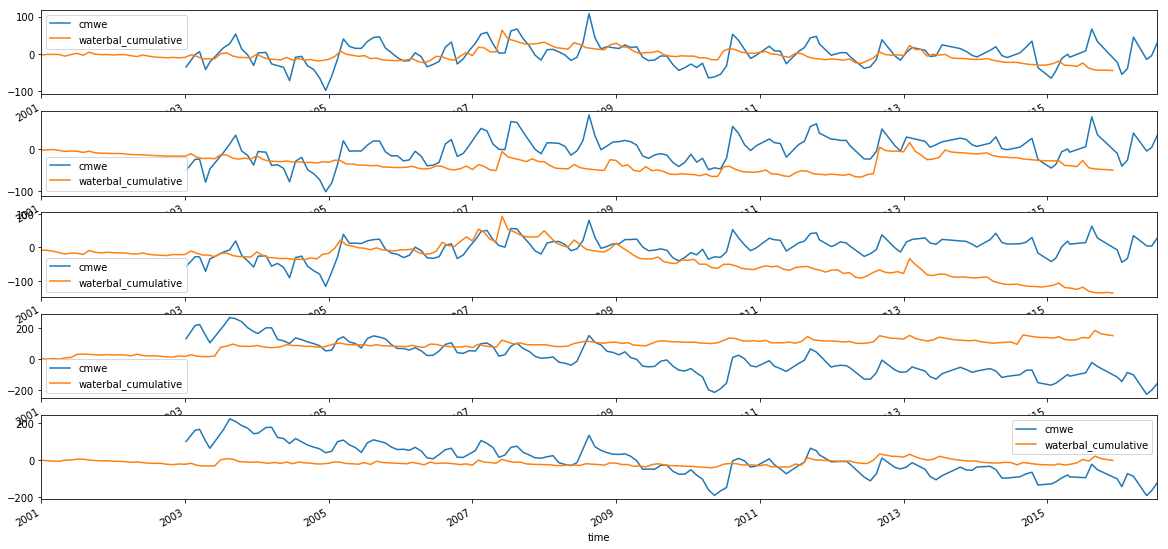

In [16]:
f, ax = plt.subplots(nrows=5, figsize=(20, 10))

for idx, masconid in enumerate(masconsid[:5]):
    # GRACE
    (gracedf[gracedf['mascon'] == masconid]).plot(ax=ax[idx], y='cmwe')

    # LIS
    (lisdf[lisdf['mascon'] == masconid]*86400).plot(ax=ax[idx], y='waterbal_cumulative')

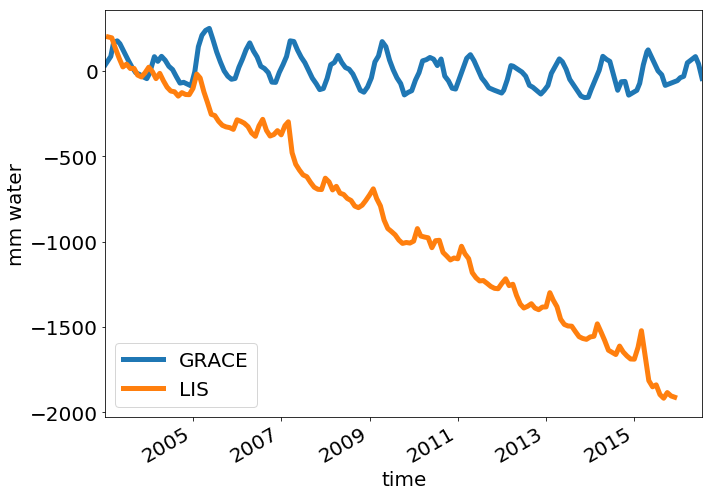

In [162]:
masconid = 8064 # Karakoram, glacier dominated
masconid = 8081 # alpine, but no ice
#masconid = 8129 # lower in the watershed
ax1 = gracedf[gracedf['mascon'] == masconid].plot(y='cmwe', label = 'GRACE',figsize=(10,7), linewidth = 5)
(lisdf[lisdf['mascon'] == masconid].loc[gracedf.iloc[0].name:]*86400).plot(ax=ax1, y='waterbal_cumulative', label = 'LIS', fontsize = 20, linewidth = 5)
plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.legend(fontsize = 20, loc = 3)
plt.tight_layout()
plt.savefig('c:\\temp\\8081.png', dpi=300, transparent = True, frameon = True, pad_inches = 0)

## Perform analysis (Whole Region)

In [140]:
grc_all = gracedf
grct = grc_all.groupby('time').mean()

In [141]:
# convert from mm/s to mm/day
wctst = lisdf.groupby('time').mean()*86400
# clip to the same time period as GRACE
wctst = wctst.loc[grct.iloc[0].name:]

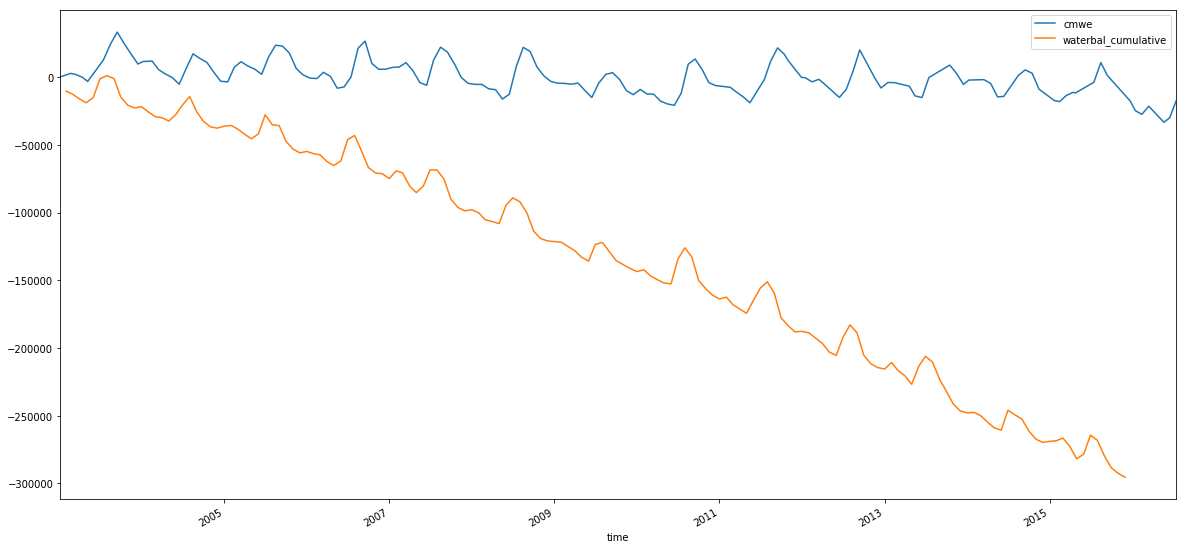

In [139]:
f, ax = plt.subplots(1, figsize=(20, 10))
grct.plot(ax=ax, y='cmwe')
wctst.plot(ax=ax, y='waterbal_cumulative')

C:\Users\Anthony Arendt\AppData\Local\conda\conda\envs\himat\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


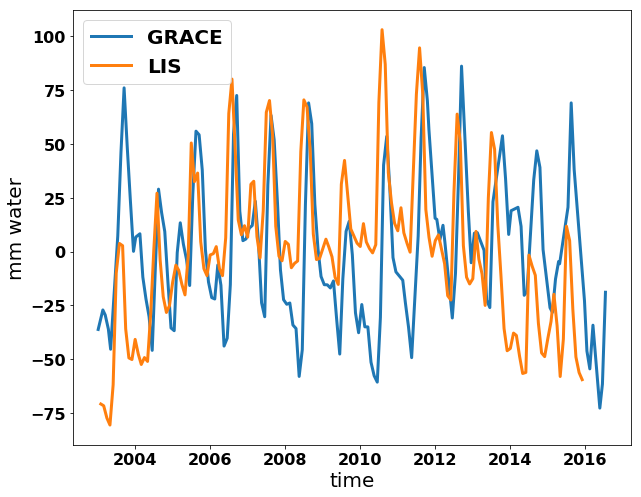

In [178]:
# detrending the LIS data

LIS_mass = wctst.waterbal_cumulative.values
LIS_decyear = pd.Series(wctst.index).apply(lambda x: pyasl.decimalYear(x))

# detrending the GRACE data

GRACE_mass = grct.cmwe.values
GRACE_decyear = g['time']['yyyy_doy_yrplot_middle'][2, :]

# plot GRACE and LIS together
plt.figure(figsize=(10,8))
plt.plot(GRACE_decyear,signal.detrend(GRACE_mass, type = 'linear'),LIS_decyear,signal.detrend(LIS_mass, type = 'linear'),linewidth = 3)
plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.legend(['GRACE','LIS'],fontsize = 20, loc = 2)

import matplotlib
font = {'family' : 'Times',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.savefig('c:\\temp\\all.png', dpi=300, transparent = True)